# Brusselator


## Model description

A chemical reaction is said to be *autocatalytic* if one of the reaction products is
also a catalyst for the same or a coupled reaction, and such a reaction is called an autocatalytic reaction.
We refer to the wikipedia article [Autocatalysis](https://en.wikipedia.org/wiki/Autocatalysis) for details.

The Brusselator is a mathematical model for a class of autocatalytic reactions.
The dynamics of the Brusselator is given by the two-dimensional ODE

$$
  \left\{ \begin{array}{lcl} \dot{x} & = & A + x^2\cdot y - B\cdot x - x \\
   \dot{y} & = & B\cdot x - x^2\cdot y \end{array} \right.
$$

The numerical values for the model's constants (in their respective units) are
given in the following table.

|Quantity|Value|
|-----|-------|
|A    | 1     |
|B    | 1.5   |

In [1]:
using ReachabilityAnalysis

const A = 1.0
const B = 1.5
const B1 = B + 1

@taylorize function brusselator!(du, u, p, t)
    x, y = u
    x² = x * x
    aux = x² * y
    du[1] = A + aux - B1*x
    du[2] = B*x - aux
    return du
end

## Reachability settings

The initial set is defined by ``x \in [0.8, 1]``, ``y \in [0, 0.2]``.
These settings are taken from [^CAS13].

In [2]:
U₀ = (0.8 .. 1.0) × (0.0 .. 0.2);
prob = @ivp(u' = brusselator!(U), u(0) ∈ U₀, dim: 2);

## Results

We use `TMJets` algorithm with sixth-order expansion in time and second order expansion
in the spatial variables.

In [3]:
sol = solve(prob, T=18.0, alg=TMJets20(orderT=6, orderQ=2));

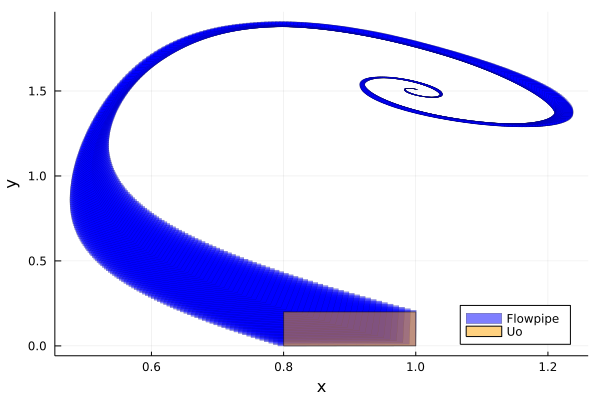

In [4]:
using Plots

plot(sol, vars=(1, 2), xlab="x", ylab="y", lw=0.2, color=:blue, lab="Flowpipe", legend=:bottomright)
plot!(U₀, color=:orange, lab="Uo")

We observe that the system converges to the equilibrium point `(1.0, 1.5)`.

Below we plot the flowpipes projected into the time domain.

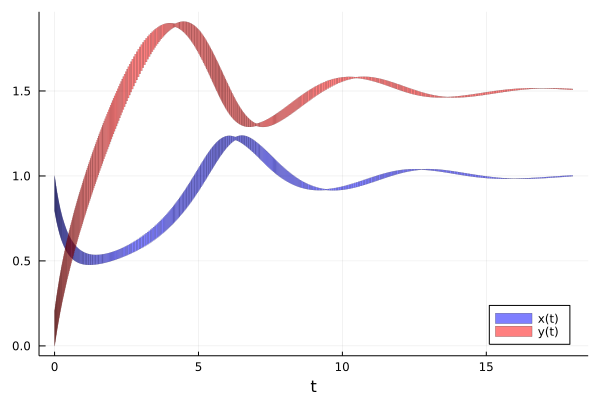

In [5]:
plot(sol, vars=(0, 1), xlab="t", lw=0.2, color=:blue, lab="x(t)", legend=:bottomright)
plot!(sol, vars=(0, 2), xlab="t", lw=0.2, color=:red, lab="y(t)")

## Changing the initial volume

The model was considered in [^GCLASG20] but using a different set of initial conditions. Let us parametrize
the initial states as a ball centered at ``x = y = 1`` and radius ``r > 0``:

In [6]:
U0(r) = Singleton([1.0, 1.0]) ⊕ BallInf(zeros(2), r)

U0 (generic function with 1 method)

The parametric initial-value problem is defined accordingly.

In [7]:
bruss(r) = @ivp(u' = brusselator!(u), u(0) ∈ U0(r), dim: 2)

bruss (generic function with 1 method)

First we solve for ``r = 0.01``:

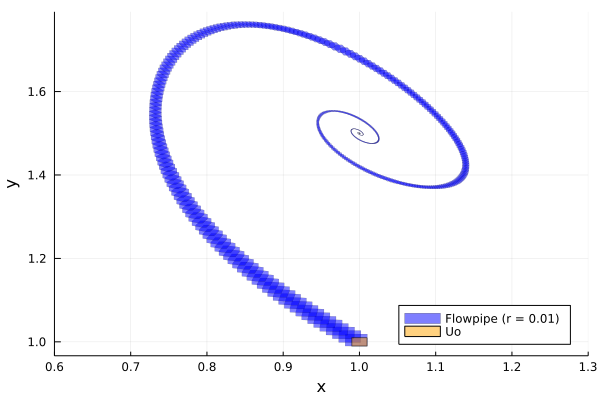

In [8]:
sol_01 = solve(bruss(0.01), T=30.0, alg=TMJets20(orderT=6, orderQ=2))

LazySets.set_ztol(Float64, 1e-15)

plot(sol_01, vars=(1, 2), xlab="x", ylab="y", lw=0.2, color=:blue, lab="Flowpipe (r = 0.01)", legend=:bottomright)

plot!(U0(0.01), color=:orange, lab="Uo", xlims=(0.6, 1.3))

We observe that the wrapping effect is controlled and the flowpipe doesn't blow up even for the large time horizon ``T = 30.0``.
Next we plot the flowpipe zoomed to the last portion and compare ``r = 0.01`` with a set of larger initial states, ``r = 0.1``.

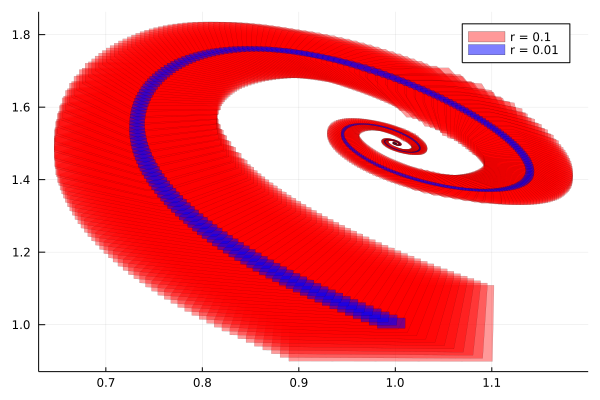

In [9]:
sol_1 = solve(bruss(0.1), T=30.0, alg=TMJets20(orderT=6, orderQ=2))

fig = plot(xlab="x", ylab="y", xlims=(0.9, 1.05), ylims=(1.43, 1.57), legend=:bottomright)

plot(sol_1, vars=(1, 2), lw=0.2, color=:red, lab="r = 0.1", alpha=.4)

plot!(sol_01, vars=(1, 2), lw=0.2, color=:blue, lab="r = 0.01")

The volume at time ``T = 9.0`` can be obtained by evaluating the flowpipe and computing the volume of the hyperrectangular overapproximation:

In [10]:
vol_01 = overapproximate(sol_01(9.0), Hyperrectangle) |> set |> volume

1.7050715277434167e-5

In [11]:
vol_1 = overapproximate(sol_1(9.0), Hyperrectangle) |> set |> volume

0.0009129014321088067

## References

[^CAS13]: X. Chen, E. Abraham, S. Sankaranarayanan. *Flow*: An Analyzer for Non-Linear Hybrid Systems.* In Proceedings of the 25th International Conference on Computer Aided Verification (CAV’13). Volume 8044 of LNCS, pages 258-263, Springer, 2013.

[^GCLASG20]: S. Gruenbacher, J. Cyranka, M. Lechner, Md. Ariful Islam,, Scott A. Smolka, R. Grosu *Lagrangian Reachtubes: The Next Generation*. arXiv: 2012.07458